In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

# preprocessing

In [2]:
imagesize=(256, 256)
batchsize=32

In [75]:
datagen = ImageDataGenerator(
    rescale=1./255
)
data= tf.keras.preprocessing.image_dataset_from_directory(
    'dataset',
    image_size =imagesize,
    batch_size=batchsize,
    shuffle=True
    
)

Found 1472 files belonging to 3 classes.


In [54]:
class_name=data.class_names
print(class_name)

['Healthy', 'Powdery', 'Rust']

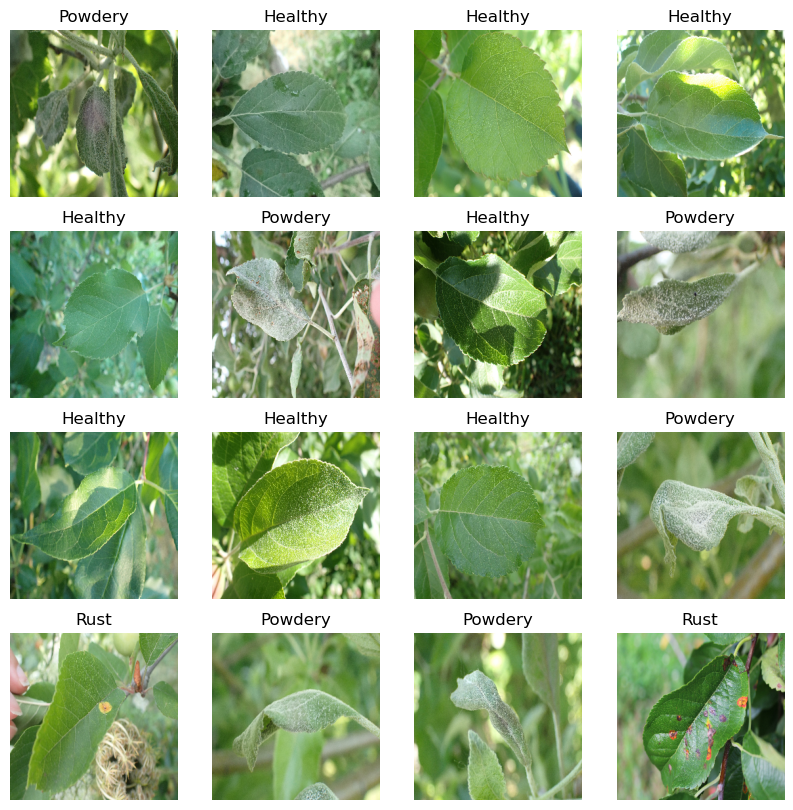

In [83]:
plt.figure(figsize=(10,10))
for image, lable in data.take(1):
    for i in range(16):
        a=plt.subplot(4,4,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[lable[i]])
        plt.axis('off')

In [105]:
le=len(data)
# int(le*0.1)
train_size=data.take(int(le*0.8))
val_size=data.skip(len(train_size)).take(int(le*0.1))
test_size=data.skip(len(train_size)+len(val_size))

print(f'train size : {len(train_size)}\nvalidation size : {len(val_size)}\ntest size : {len(test_size)}')

train size : 36
validation size : 4
test size : 6


In [116]:
# this funcation to calculate the train_test_split

def dataset_split(dataset,train_size=0.8,test_size=0.1,val_size=0.1,shuffle=True,shuffle_size=500):
    le=len(dataset)
#   calculating the data size for train, validation, test
    tr_size=int(le*train_size)
    vl_size=int(le*val_size)
#   split the dataset using the calcualted size
    tr_da=dataset.take(tr_size)
    val_da=dataset.skip(tr_size).take(vl_size)
    te_da = dataset.skip(tr_size).skip(vl_size)
    
    return tr_da,val_da,te_da
    

In [117]:
train_data,val_data,test_data=dataset_split(data)

In [162]:
#applying tenserflow data pipeline
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [125]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imagesize[0],imagesize[0]),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [123]:
data_aggumentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(.3),
    layers.experimental.preprocessing.RandomZoom(.1)
])

# Model

In [137]:
imagesize=(batchsize,256,256,3)
model = models.Sequential([
    resize_and_rescale,
    data_aggumentation,
    #cnn layers
    layers.Conv2D(45,(3,3),activation='relu',input_shape=imagesize),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(68,(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(68,(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(68,(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(68,(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    #Dense layers
    layers.Flatten(),
    layers.Dense(70,activation='relu'),
    layers.Dense(len(class_name),activation='softmax')
])
model.build(input_shape=imagesize)

In [138]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_31 (Conv2D)          (32, 254, 254, 45)        1260      
                                                                 
 max_pooling2d_30 (MaxPooli  (32, 127, 127, 45)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (32, 125, 125, 68)        27608     
                                                                 
 max_pooling2d_31 (MaxPooli  (32, 62, 62, 68)          0         
 ng2D)                                               

In [145]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [149]:
history=model.fit(
    train_data,
    epochs=30,
    batch_size=batchsize,
    validation_data=val_data,
    verbose=1)

Epoch 1/30
36/36 [==============================] - 37s 1s/step - loss: 0.6744 - accuracy: 0.6701 - val_loss: 0.7865 - val_accuracy: 0.6328
Epoch 2/30
36/36 [==============================] - 37s 1s/step - loss: 0.5547 - accuracy: 0.7760 - val_loss: 0.5094 - val_accuracy: 0.8359
Epoch 3/30
36/36 [==============================] - 36s 999ms/step - loss: 0.4394 - accuracy: 0.8247 - val_loss: 0.4160 - val_accuracy: 0.8750
Epoch 4/30
36/36 [==============================] - 30s 828ms/step - loss: 0.3042 - accuracy: 0.8950 - val_loss: 0.1973 - val_accuracy: 0.9297
Epoch 5/30
36/36 [==============================] - 30s 841ms/step - loss: 0.2872 - accuracy: 0.9036 - val_loss: 0.3512 - val_accuracy: 0.9062
Epoch 6/30
36/36 [==============================] - 30s 832ms/step - loss: 0.2357 - accuracy: 0.9167 - val_loss: 0.1618 - val_accuracy: 0.9531
Epoch 7/30
36/36 [==============================] - 34s 943ms/step - loss: 0.2269 - accuracy: 0.9236 - val_loss: 0.2595 - val_accuracy: 0.9062
Epoch

In [150]:
model.evaluate(test_data)

6/6 [==============================] - 6s 184ms/step - loss: 0.1431 - accuracy: 0.9635


[0.14310646057128906, 0.9635416865348816]

In [157]:
pre_value=model.predict(test_data)
pre_value

6/6 [==============================] - 1s 181ms/step


array([[9.99904394e-01, 1.50270262e-06, 9.40382597e-05],
       [1.16115025e-05, 3.65980839e-07, 9.99988079e-01],
       [9.97633696e-01, 2.09914288e-04, 2.15638801e-03],
       [9.99998927e-01, 3.25015232e-12, 1.05575396e-06],
       [2.29648367e-01, 7.70262957e-01, 8.86864800e-05],
       [2.57074673e-09, 3.51520703e-06, 9.99996543e-01],
       [5.11648841e-06, 5.69643162e-04, 9.99425292e-01],
       [1.09134853e-04, 1.56286210e-02, 9.84262228e-01],
       [1.50328632e-23, 5.40677698e-14, 1.00000000e+00],
       [1.90506053e-12, 1.42155170e-16, 1.00000000e+00],
       [9.99997497e-01, 9.92107463e-09, 2.51120650e-06],
       [2.32892287e-22, 4.10397027e-19, 1.00000000e+00],
       [9.99764979e-01, 7.63755888e-05, 1.58652096e-04],
       [8.50967169e-01, 1.48206219e-01, 8.26511998e-04],
       [7.58746080e-03, 9.77364957e-01, 1.50476210e-02],
       [1.00000000e+00, 1.84350970e-08, 1.03228261e-08],
       [9.73804054e-05, 5.56169616e-05, 9.99846935e-01],
       [9.99924302e-01, 5.70292

In [177]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 36}

In [180]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [182]:
accuracy=history.history["accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
val_accuracy=history.history["val_accuracy"]

Text(0.5, 1.0, 'training and validation accuracy')

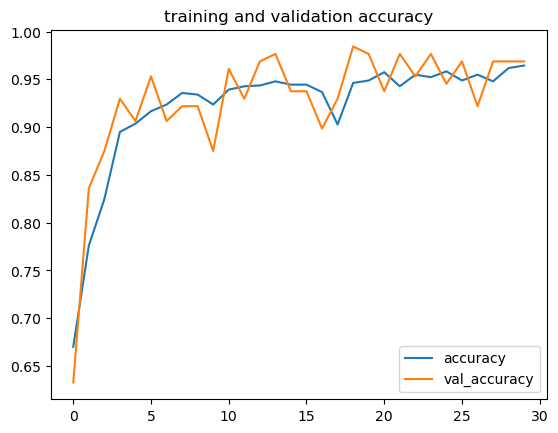

In [209]:
#Accuracy plot
plt.plot(range(30),accuracy,label='accuracy')
plt.plot(range(30),val_accuracy,label='val_accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')



Text(0.5, 1.0, 'loss and validation loss')

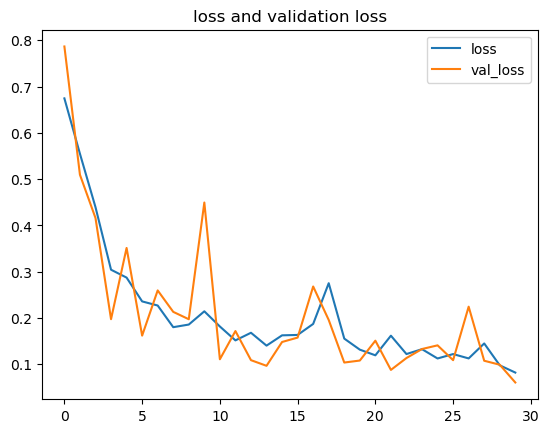

In [194]:
#loss plot
plt.plot(range(30),loss,label='loss')
plt.plot(range(30),val_loss,label='val_loss')
plt.legend(loc='upper right')
plt.title('trining and validation loss')

1/1 [==============================] - 0s 191ms/step
real value : Powdery
predected vlaue : Powdery
confident : 76.2%


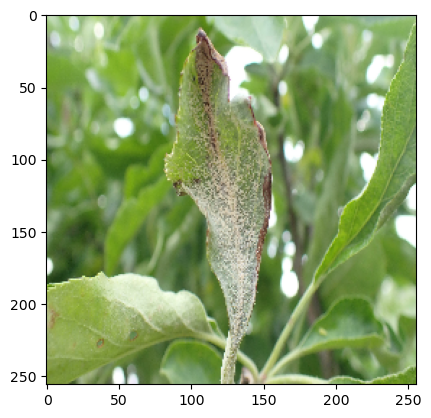

In [233]:
for image,lable in test_data.take(1):
    img=image[0].numpy().astype('uint8')
    lab=lable[0].numpy() 
    plt.imshow(img)
    pre=model.predict(image)
    print(f'real value : {class_name[lab]}')
    print(f'predected vlaue : {class_name[np.argmax(pre[0])]}')
    print(f'confident : {round(100*(max(pre[0])),2)}%')

In [292]:
def fun_predect(model,image):
    a=tf.keras.preprocessing.image.img_to_array(image)
    a=tf.expand_dims(a,0)
    pr=model.predict(a)
    lable = class_name[np.argmax(pr[0])]
    confidence = round(100*(np.max(pr[0])),2)
    return lable, confidence
    


1/1 [==============================] - 0s 18ms/step


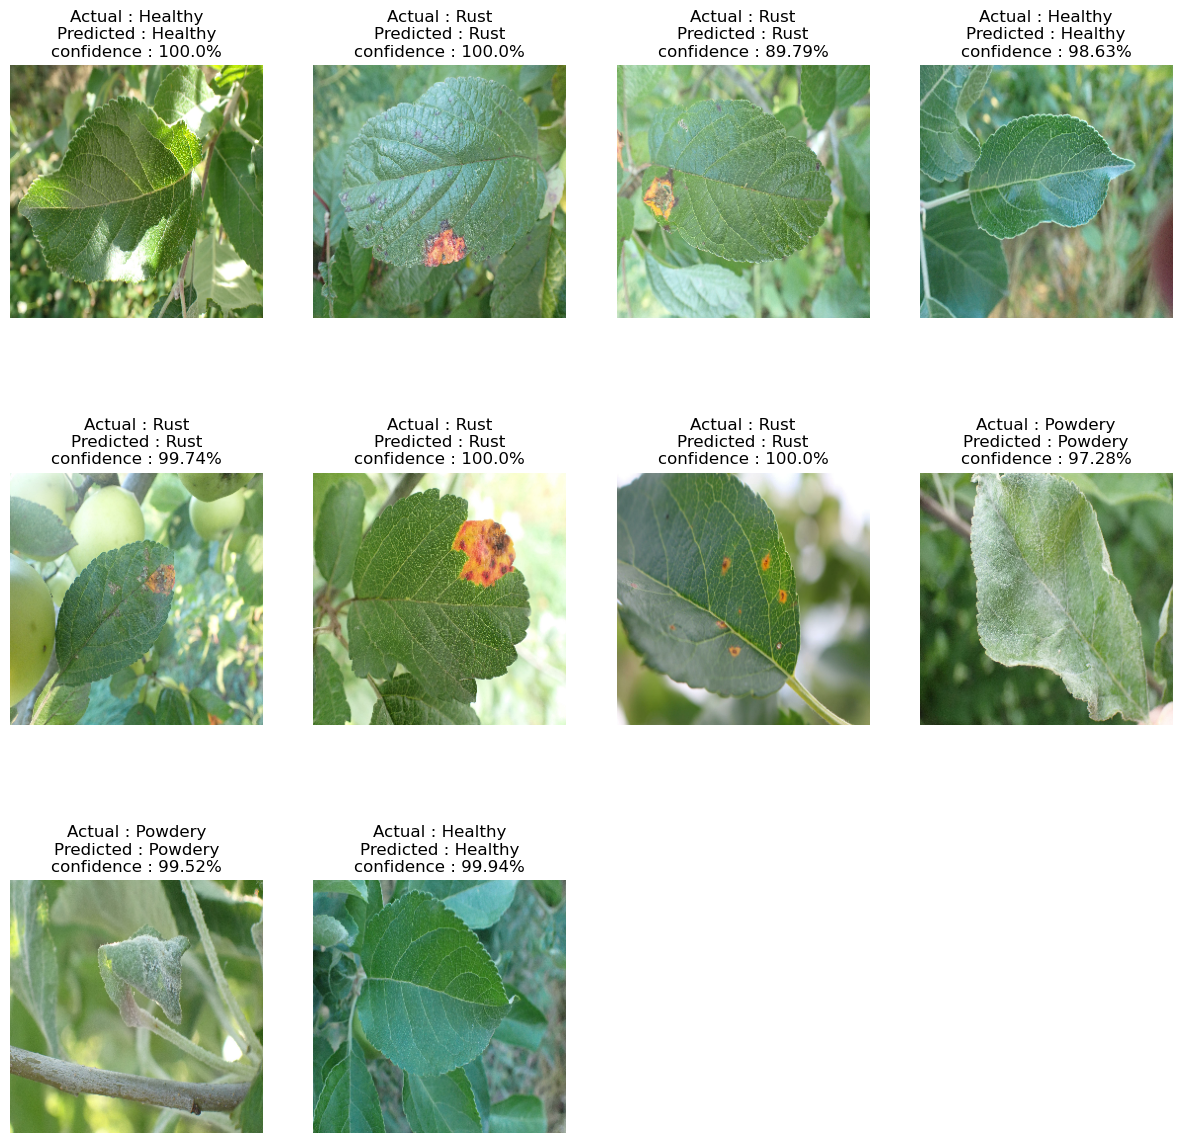

In [296]:
#     print(tf.keras.preprocessing.image.img_to_array(image))
plt.figure(figsize=(15,15))
for i,j in test_data.take(1):
    for  k in range(10):
        plt.subplot(3,4,k+1)
        pre_class, confidence = fun_predect(model,i[k].numpy())
        plt.imshow(i[k].numpy().astype('uint8'))
        plt.title(f'Actual : {class_name[j[k]]}\nPredicted : {pre_class}\nconfidence : {confidence}%')
        plt.axis('off')
    plt.show()

In [299]:
model_version=1
model.save(f'./model/{model_version}')

INFO:tensorflow:Assets written to: ./model/1\assets


INFO:tensorflow:Assets written to: ./model/1\assets
